# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.reindex(survey_fields, axis=1)
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Create plots with matplotlib

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

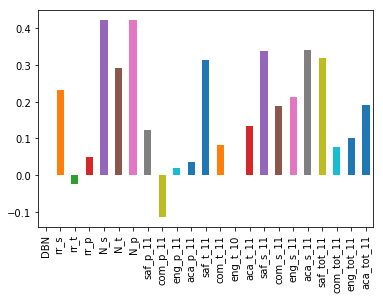

In [11]:
# bar plot of correlations between survey_fields and sat_score
combined.corr()["sat_score"].reindex(survey_fields).plot.bar()

In the table above you can see that N_s, N_t and N_p are highly correlated to sat_score.
The response rate (rr_s) is also correlated to sat_score which means that students with higher scores are more likely to respond to the survey.

In the table above it can be found that the measurement of how teachers and students perceive safety at school (saf_t_11 and saf_s_11) correlate highly with sat_score. To investigate a bit more about this, in the scatter plot below the schools with low safety scores will be pointed out.

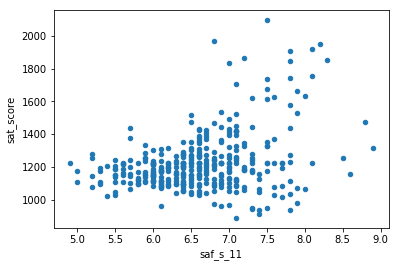

In [12]:
# Scatter plot between student safety scores and SAT score
combined.plot.scatter("saf_s_11", "sat_score")

It lookes like there is a weak correlation between safety and sat_scores. High sat_scores belong to high safety, but in the lower sat_scores there is a wide range of safety scores.

In the scatter plot above it can be found that the measurement how teachers and students perceive safety at school is correlating highly with sat_score. The plots below will be used to investigate safety scores a bit more and will point out which schools have low safety scores.

# Create a map with average safety scores for each district

In [13]:
# First the safety scores are grouped by School district
group = combined.groupby("school_dist")
group = group.agg(numpy.mean)
group.reset_index(inplace=True)
group['saf_s_11']

0     6.768611
1     6.910660
2     6.716667
3     6.885714
4     6.314286
5     6.950000
6     6.800000
7     6.364697
8     6.655000
9     6.577273
10    6.186667
11    7.116667
12    6.407692
13    6.685714
14    6.177778
15    5.875000
16    6.007143
17    6.190909
18    6.150000
19    7.120000
20    6.390909
21    7.025000
22    6.233333
23    7.107692
24    6.912500
25    6.760000
26    6.390000
27    6.627273
28    6.075000
29    7.033333
30    6.530000
31    6.766667
Name: saf_s_11, dtype: float64

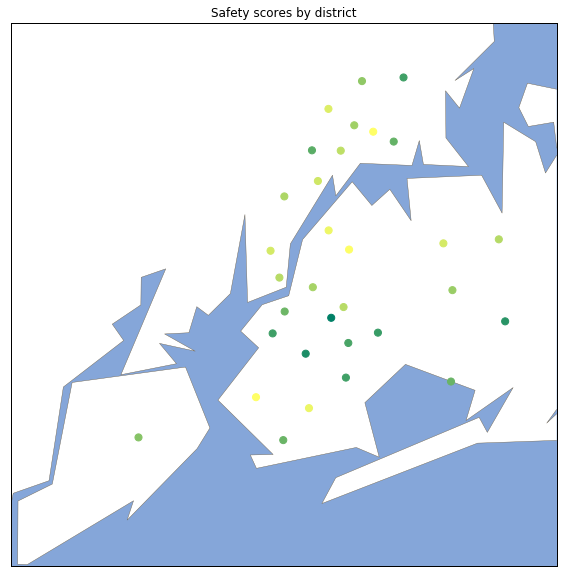

In [14]:
# Plot the safety scores grouped by school district on a map
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Safety scores by district")
m = Basemap(projection='merc', llcrnrlat=40.496044, urcrnrlat=40.915256, llcrnrlon=-74.255735, urcrnrlon=-73.700272, resolution='i')

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
                 
longitudes = group["lon"].tolist()
latitudes = group["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=group["saf_s_11"], cmap="summer")

plt.show()


In the map above it is shown that the districts with the lowest safety scores are in the top of the map (the Bronx and Queens). The highest scores are in Brooklyn.

# Racial diffences in SAT scores

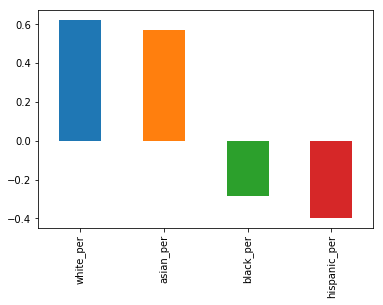

In [15]:
# bar plot of the correlations of the racial differences
racial_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][racial_fields].plot.bar()

Schools with high percentage White or Asian have high SAT scores. Schools with high percentage Black or Hispanic students have low SAT scores.

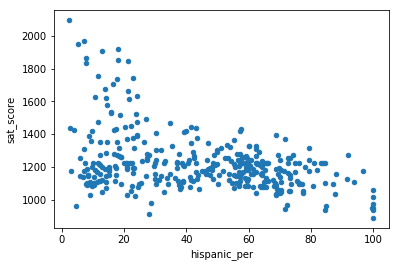

In [16]:
# Scatter plot of hispanic_per vs. sat_score
combined.plot.scatter("hispanic_per", "sat_score")

In the scatter plot it can be found that a high hispanic percentage results in a low SAT score. High SAT scores can be found at the lower hispanic percentages, but there are also low SAT scores at low hispanic percentage schools.

In [17]:
# Schools with hispanic percentage greater than 95%
Hispanic_95 = combined[combined["hispanic_per"] > 95]
Hispanic_95[["SCHOOL NAME", "sat_score"]]

,SCHOOL NAME,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0
253,MULTICULTURAL HIGH SCHOOL,887.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0


Pan American International High School on Wikipedia:
Today the network serves approximately 6,000 students annually from 90 countries. Over 90% of students receive free or reduced price lunch, and 86 percent of students come from low-income families. High percentages of students have had interrupted formal education due to political, social, or economic factors in their native countries. 70 percent of students have been separated from one or both parents during their family's immigration to the United States.

From the text above it is clear why these schools have lower SAT scores.

In [18]:
# Schools with hispanic_per less than 10% and an average SAT score greater than 1800
hispanic_10 = combined[combined["hispanic_per"] < 10]
hispanic_10 = hispanic_10[hispanic_10["sat_score"] > 1800]
hispanic_10[["SCHOOL NAME" , "sat_score"]]

,SCHOOL NAME,sat_score
37,STUYVESANT HIGH SCHOOL,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0


On Wikipedia the following can be found about [Specialized High Schools Admissions Test](https://en.wikipedia.org/wiki/Specialized_High_Schools_Admissions_Test): Admission to the 5 schools above involves passing the Specialized High Schools Admissions Test. 

In other words the best students are selected for these schools and it explains the high average SAT scores.

# Gender differences

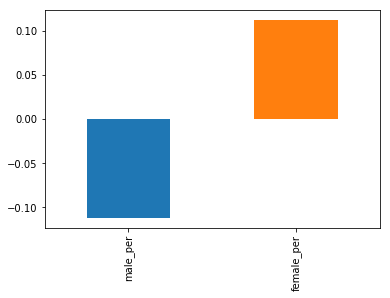

In [19]:
# bar plot of the correlations between gender and sat_score
gender = ["male_per", "female_per"]
combined.corr()["sat_score"][gender].plot.bar()

High male percentages correlates with low SAT scores and high female percentages correlates with high SAT scores.

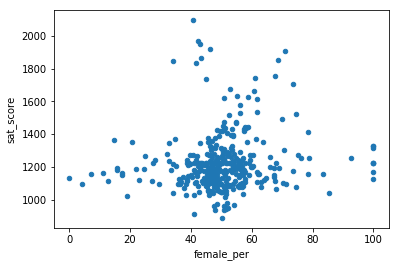

In [20]:
# Investigate schools with high SAT scores and a high female%
combined.plot.scatter("female_per", "sat_score")

The big dot in the middle of the scatter plot above means the average school has a male/female dividing of 50/50. High SAT scores are at schools with female_per around 50. Schools with high female_per have average SAT scores.
Between female_per 60 and 80 some high SAT_scores exist which will be analysed below.

In [21]:
# Schools with female_per greater than 60% and average SAT score greater than 1700
female_60 = combined[combined["female_per"] > 60]
female_60 = female_60[female_60["sat_score"] > 1700]
female_60[["SCHOOL NAME", "sat_score"]]

,SCHOOL NAME,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0
60,BEACON HIGH SCHOOL,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0


All schools above use tests for admission and that explains the high average sat_score. The high female_per of these schools can be explained by the extracurricular activities like sports, theater and music which is more attractive to females.

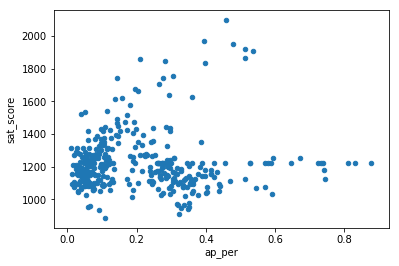

In [22]:
# Calculate the percentage of students in each school that took an Advanced Placement (AP) exam
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
combined.plot.scatter("ap_per", "sat_score")

There seems to be a small correlation between AP exams and SAT score, but not very strong.

# Class Size

In [23]:
# Determing whether there's a correlation between class size and SAT scores
# Which class_size columns exist in the combined dataset?
class_columns = []
columns = combined.columns
for item in columns:
    if "CLASS" in item:
        class_columns.append(item)
class_columns

['AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS']

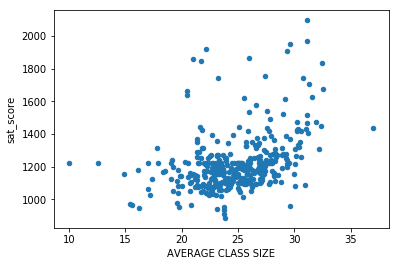

In [25]:
# Create a scatter plot of Average class size vs. Sat score
combined.plot.scatter("AVERAGE CLASS SIZE", "sat_score")

In the scatter plot above it seems there is no correlation between Average class sizes and SAT scores. 
For the High Sat scores it is not nessary to be in a class of small size.

# Next steps

In the notebook above there is quite a bit of investigation into relationships between demographics and SAT scores. There's still quite a bit of analysis left to do, however. Here are some potential next steps:
     - Figuring out which neighborhoods have the best schools
       - If we combine this information with a dataset containing property values, 
         we could find the least expensive neighborhoods that have good schools.
     - Investigating the differences between parent, teacher, and student responses to surveys.
     - Assigning scores to schools based on sat_score and other attributes.